# K-Means Clustering for Data Mining (Resorts Dataset)
This notebook completes the full K-means clustering workflow required in the assignment using **resorts_data.csv**.

**What you will see:** data import, exploration, missing data handling, label encoding, scatter plot matrix, correlation analysis + heatmap, elbow method, K-means clustering, cluster centers, adding clusters back to data ,Perform PCAe.

In [97]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


## 1) Import the data files into a new DataFrame
Some CSV files are not UTF‑8 encoded. The code below tries common encodings automatically.

In [42]:

from pathlib import Path

csv_path = Path(r"C:\Users\vanam\Downloads\resorts_data.csv")

def read_csv_robust(path: Path):
    encodings_to_try = ["utf-8", "utf-8-sig", "cp1252", "latin1"]
    last_err = None
    for enc in encodings_to_try:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

df = read_csv_robust(csv_path)

print("Shape:", df.shape)
display(df.head())


Shape: (375, 11)


,ResortName,NearestCity,StateOrProvince,PeakElevationInFeet,BaseElevationInFeet,VerticalDropInFeet,SkiableAcres,TotalTrails,TotalLifts,AvgAnnualSnowfallInInches,AdultLiftTicketPriceUSD
0,Cloudmont Resort,Mentone,Alabama,1800,1650,150,9,2,2,250,40
1,Mount Eyak,Cordova,Alaska,1200,400,800,100,10,2,350,30
2,Hilltop,Anchorage,Alaska,780,486,294,30,13,3,69,34
3,Moose Mountain,Fairbanks,Alaska,1985,685,1300,200,40,0,70,40
4,Arctic Valley,Anchorage,Alaska,4000,2500,1500,320,24,3,250,40


## 2) Explore and describe the data

In [44]:

display(df.info())
display(df.describe(include="all").T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ResortName                   375 non-null    object
 1   NearestCity                  375 non-null    object
 2   StateOrProvince              375 non-null    object
 3   PeakElevationInFeet          375 non-null    int64 
 4   BaseElevationInFeet          375 non-null    int64 
 5   VerticalDropInFeet           375 non-null    int64 
 6   SkiableAcres                 375 non-null    int64 
 7   TotalTrails                  375 non-null    int64 
 8   TotalLifts                   375 non-null    int64 
 9    AvgAnnualSnowfallInInches   375 non-null    int64 
 10   AdultLiftTicketPriceUSD     375 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 32.4+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ResortName,375,370,Crystal Mountain,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NearestCity,375,328,Aspen,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StateOrProvince,375,43,Colorado,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PeakElevationInFeet,375.0,NaN,NaN,NaN,4809.632,3676.439794,310.0,1500.0,3500.0,8015.0,13487.0
BaseElevationInFeet,375.0,NaN,NaN,NaN,3470.509333,3071.095406,33.0,871.0,1820.0,6334.0,10800.0
VerticalDropInFeet,375.0,NaN,NaN,NaN,1322.224,1027.521369,100.0,500.0,1016.0,2000.0,5620.0
SkiableAcres,375.0,NaN,NaN,NaN,735.685333,1219.376205,6.0,85.0,202.0,800.0,8464.0
TotalTrails,375.0,NaN,NaN,NaN,48.504,45.458442,1.0,19.0,32.0,62.0,348.0
TotalLifts,375.0,NaN,NaN,NaN,7.978667,5.988364,0.0,4.0,6.0,10.0,43.0
AvgAnnualSnowfallInInches,375.0,NaN,NaN,NaN,187.277333,132.469421,9.0,80.0,150.0,277.5,643.0


## 3) Missing data

In [46]:

missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]

print("Missing values per column:")
display(missing)

print("\nMissing % per column:")
display((df.isna().mean()*100).sort_values(ascending=False).round(2))


Missing values per column:


Series([], dtype: int64)


Missing % per column:


ResortName                     0.0
NearestCity                    0.0
StateOrProvince                0.0
PeakElevationInFeet            0.0
BaseElevationInFeet            0.0
VerticalDropInFeet             0.0
SkiableAcres                   0.0
TotalTrails                    0.0
TotalLifts                     0.0
 AvgAnnualSnowfallInInches     0.0
 AdultLiftTicketPriceUSD       0.0
dtype: float64

## 4) Handle missing data
- **Numeric columns:** fill with median
- **Categorical columns:** fill with mode (most frequent)

This approach keeps most rows and makes the dataset usable for clustering.

In [48]:

df_clean = df.copy()

num_cols = df_clean.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in df_clean.columns if c not in num_cols]

for c in num_cols:
    if df_clean[c].isna().any():
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())

for c in cat_cols:
    if df_clean[c].isna().any():
        mode_val = df_clean[c].mode(dropna=True)
        fill_val = mode_val.iloc[0] if len(mode_val) else "Unknown"
        df_clean[c] = df_clean[c].fillna(fill_val)

print("Any missing left? ->", df_clean.isna().any().any())


Any missing left? -> False


## 5) Label encoding
Apply label encoding for:
- **ResortName**
- **NearestCity**
- **StateOrProvince**


In [50]:

df_encoded = df_clean.copy()

encode_cols = ["ResortName", "NearestCity", "StateOrProvince"]
encoders = {}

for c in encode_cols:
    if c in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[c] = le.fit_transform(df_encoded[c].astype(str))
        encoders[c] = le
    else:
        print(f"Column '{c}' not found. Available columns: {list(df_encoded.columns)}")

display(df_encoded.head())


,ResortName,NearestCity,StateOrProvince,PeakElevationInFeet,BaseElevationInFeet,VerticalDropInFeet,SkiableAcres,TotalTrails,TotalLifts,AvgAnnualSnowfallInInches,AdultLiftTicketPriceUSD
0,85,191,0,1800,1650,150,9,2,2,250,40
1,193,64,1,1200,400,800,100,10,2,350,30
2,132,6,1,780,486,294,30,13,3,69,34
3,187,88,1,1985,685,1300,200,40,0,70,40
4,12,6,1,4000,2500,1500,320,24,3,250,40


## 6) Describe the transformed data (after cleaning + encoding)

In [52]:

display(df_encoded.describe().T)


,count,mean,std,min,25%,50%,75%,max
ResortName,375.0,183.968000,106.809436,0.0,92.5,184.0,275.5,369.0
NearestCity,375.0,163.389333,95.042337,0.0,81.5,163.0,248.5,327.0
StateOrProvince,375.0,20.080000,12.461878,0.0,8.0,19.0,31.0,42.0
PeakElevationInFeet,375.0,4809.632000,3676.439794,310.0,1500.0,3500.0,8015.0,13487.0
BaseElevationInFeet,375.0,3470.509333,3071.095406,33.0,871.0,1820.0,6334.0,10800.0
VerticalDropInFeet,375.0,1322.224000,1027.521369,100.0,500.0,1016.0,2000.0,5620.0
SkiableAcres,375.0,735.685333,1219.376205,6.0,85.0,202.0,800.0,8464.0
TotalTrails,375.0,48.504000,45.458442,1.0,19.0,32.0,62.0,348.0
TotalLifts,375.0,7.978667,5.988364,0.0,4.0,6.0,10.0,43.0
AvgAnnualSnowfallInInches,375.0,187.277333,132.469421,9.0,80.0,150.0,277.5,643.0


## 7) Scatter plot matrix (data exploration)
We sample up to 500 rows for readability.

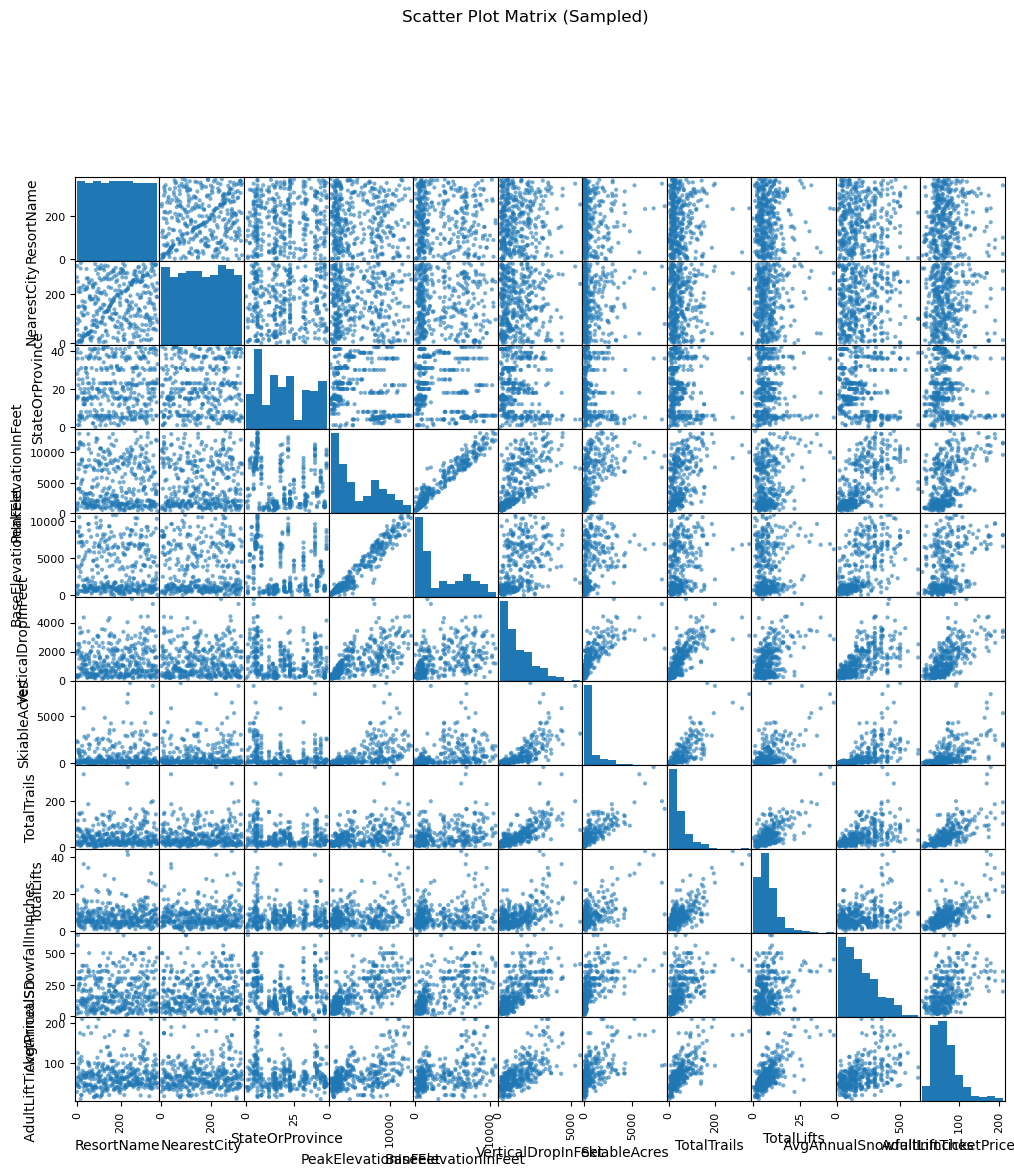

In [54]:

from pandas.plotting import scatter_matrix

num_df_all = df_encoded.select_dtypes(include=["number"]).copy()
sample_n = min(500, len(num_df_all))
sample = num_df_all.sample(n=sample_n, random_state=42)

scatter_matrix(sample, figsize=(12, 12), diagonal="hist", alpha=0.6)
plt.suptitle("Scatter Plot Matrix (Sampled)", y=1.02)
plt.show()


## 8) Correlation analysis
Correlation shows linear relationships between numeric features.

In [56]:

num_df = df_encoded.select_dtypes(include=["number"]).copy()
corr = num_df.corr(numeric_only=True)

# Top correlations (absolute)
corr_abs = corr.abs().unstack().sort_values(ascending=False)
corr_abs = corr_abs[corr_abs < 0.999999]  # remove self-correlation pairs
print("Top correlated feature pairs (absolute correlation):")
display(corr_abs.head(15))


Top correlated feature pairs (absolute correlation):


PeakElevationInFeet        BaseElevationInFeet          0.967369
BaseElevationInFeet        PeakElevationInFeet          0.967369
TotalTrails                SkiableAcres                 0.807665
SkiableAcres               TotalTrails                  0.807665
TotalTrails                VerticalDropInFeet           0.763776
VerticalDropInFeet         TotalTrails                  0.763776
SkiableAcres               VerticalDropInFeet           0.745041
VerticalDropInFeet         SkiableAcres                 0.745041
TotalLifts                 TotalTrails                  0.734538
TotalTrails                TotalLifts                   0.734538
 AdultLiftTicketPriceUSD   TotalTrails                  0.714264
TotalTrails                 AdultLiftTicketPriceUSD     0.714264
 AdultLiftTicketPriceUSD   TotalLifts                   0.705923
TotalLifts                  AdultLiftTicketPriceUSD     0.705923
 AdultLiftTicketPriceUSD   VerticalDropInFeet           0.684494
dtype: float64

### 8.1 Correlation heatmap

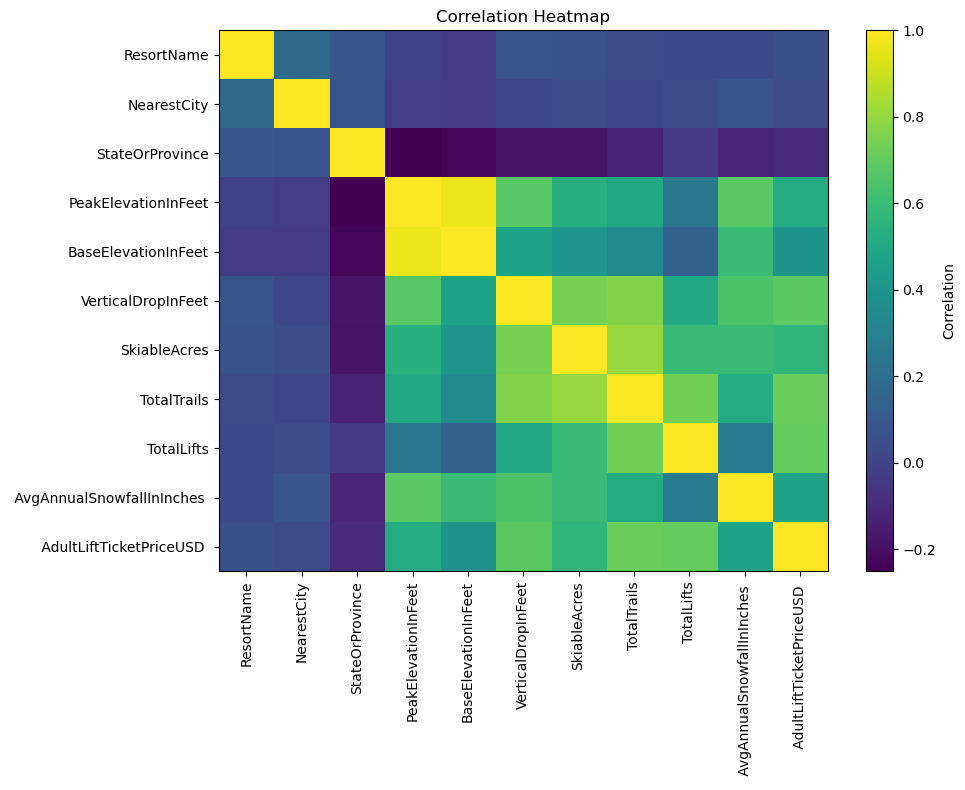

In [58]:

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


## 9) Elbow method analysis (data partition)
We scale features before K-means so features with larger values do not dominate distance calculations.

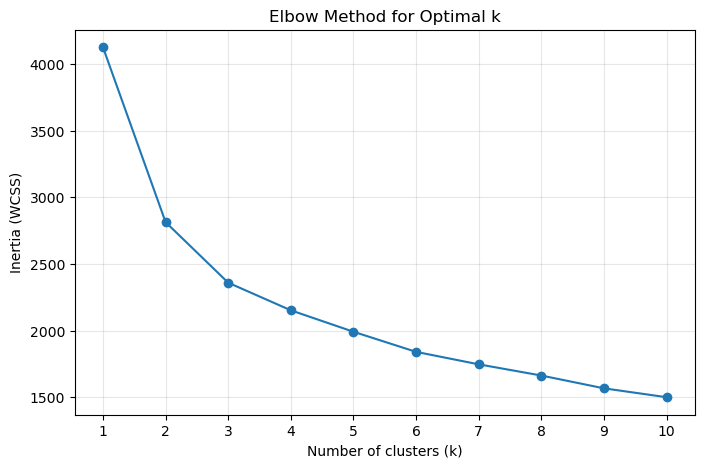

In [95]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

X = df_encoded.select_dtypes(include=["number"]).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertias = []
k_values = range(1, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_values), inertias, marker="o")
plt.xticks(list(k_values))
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.grid(True, alpha=0.3)
plt.show()


## 10) Apply K-means clustering
Choose **k_chosen** based on your elbow plot.

In [93]:

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

k_chosen = 4  # <-- update after inspecting the elbow plot

kmeans = KMeans(n_clusters=k_chosen, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

print("Cluster counts:")
unique, counts = np.unique(clusters, return_counts=True)
display(pd.DataFrame({"cluster": unique, "count": counts}))


Cluster counts:


,cluster,count
0,0,205
1,1,66
2,2,18
3,3,86


## 11) Review the cluster centers
We inverse-transform cluster centers back into original feature units for interpretation.

In [64]:

centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(centers_original, columns=X.columns)
centers_df.index = [f"Cluster {i}" for i in range(k_chosen)]

display(centers_df.round(3))


,ResortName,NearestCity,StateOrProvince,PeakElevationInFeet,BaseElevationInFeet,VerticalDropInFeet,SkiableAcres,TotalTrails,TotalLifts,AvgAnnualSnowfallInInches,AdultLiftTicketPriceUSD
Cluster 0,180.985,162.907,22.888,1913.620,1200.766,711.034,148.151,29.024,6.785,100.390,56.512
Cluster 1,204.106,166.682,19.379,7795.106,5126.152,2647.303,1870.833,91.409,10.803,342.212,98.606
Cluster 2,202.389,187.111,11.333,10858.278,7474.111,3396.722,4239.444,171.444,25.556,348.111,165.556
Cluster 3,171.767,157.047,15.756,8155.744,6772.372,1328.012,531.698,36.279,4.977,241.826,58.849


## 12) Add the clusters to the original data

In [66]:

df_with_clusters = df_clean.copy()
df_with_clusters["Cluster"] = clusters

display(df_with_clusters.head())


,ResortName,NearestCity,StateOrProvince,PeakElevationInFeet,BaseElevationInFeet,VerticalDropInFeet,SkiableAcres,TotalTrails,TotalLifts,AvgAnnualSnowfallInInches,AdultLiftTicketPriceUSD,Cluster
0,Cloudmont Resort,Mentone,Alabama,1800,1650,150,9,2,2,250,40,0
1,Mount Eyak,Cordova,Alaska,1200,400,800,100,10,2,350,30,0
2,Hilltop,Anchorage,Alaska,780,486,294,30,13,3,69,34,0
3,Moose Mountain,Fairbanks,Alaska,1985,685,1300,200,40,0,70,40,0
4,Arctic Valley,Anchorage,Alaska,4000,2500,1500,320,24,3,250,40,3


## 13) Perform PCA
PCA helps visualize clusters in 2 dimensions.

In [68]:

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = clusters

print("Explained variance ratio:", pca.explained_variance_ratio_.round(4))
display(pca_df.head())


Explained variance ratio: [0.4588 0.1397]


,PC1,PC2,Cluster
0,-1.812669,-1.169108,0
1,-1.507882,-1.048062,0
2,-2.377757,-0.779158,0
3,-1.633085,-0.613074,0
4,-0.720454,-1.793812,3


### 13.1 PCA plot (clusters in 2D)

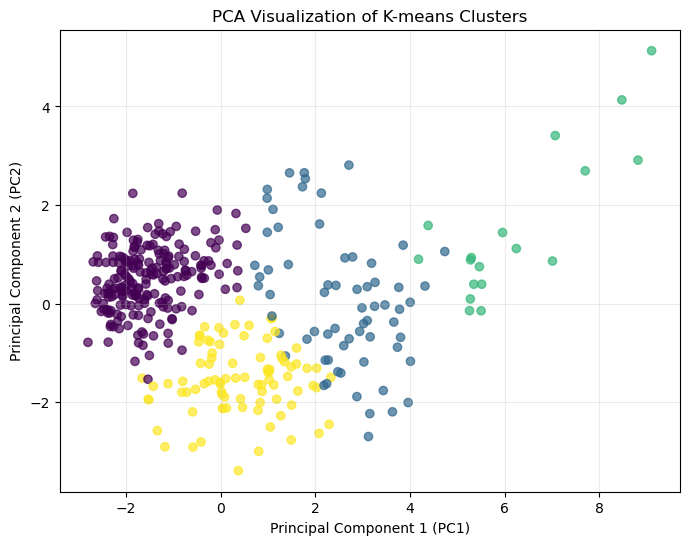

In [70]:

plt.figure(figsize=(8, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster"], alpha=0.7)
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Visualization of K-means Clusters")
plt.grid(True, alpha=0.25)
plt.show()


###  K-means Data Segmentation Experience
In this project, K-means clustering was used to group resorts based on similar characteristics in the dataset. Before applying the model, the data was prepared by handling missing values, converting categorical variables into numeric form using label encoding, and standardizing the features. Standardization was necessary because K-means uses distance to form clusters, and features with larger values could otherwise influence the results more than others.

The Elbow Method was used to identify the appropriate number of clusters. Based on the elbow plot, four clusters (k = 4) were selected because the reduction in inertia started to level off at that point, indicating that adding more clusters would not significantly improve the segmentation.

After running the K-means algorithm, the resorts were divided into four groups with different sizes. Some clusters contained more resorts, suggesting common resort types, while a smaller cluster indicated resorts with unique features. This shows that the dataset contains a mix of resort categories rather than one uniform group.

By reviewing the cluster centers, it became easier to understand how the groups differed from one another. Certain clusters appeared to represent resorts with higher values in some features, possibly indicating more premium options, while others reflected more average or budget-friendly resorts.

Principal Component Analysis (PCA) was also performed to visualize the clusters in two dimensions. The plot showed a reasonable level of separation between the groups, suggesting that the K-means model was effective in identifying patterns within the data.

Overall, this clustering process helped transform raw data into meaningful segments. Such segmentation can support better decision-making by allowing businesses to understand differences among resorts, improve marketing strategies, and provide services that better match customer needs.